# Kickstarter Data Analysis

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier  

# to not print out warnings in jupyter notebook (NOT FOR OTHER EDITORS)
import warnings
warnings.simplefilter("ignore")

In [2]:
pd.set_option('float_format', '{:f}'.format)
pd.set_option("precision", 2)

In [3]:
# import data from raw CSV file
ks = pd.read_csv('raw_data.csv', dtype = {'category': 'category', 'main_category': 'category', 'state': 'category'}, index_col = 0)

# Data Pre-Processing

In [4]:
# filter dataset
data = ks.query('country == "US"').loc[:, ['category', 'main_category', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers']].query('state == "successful" or state == "failed"')

# drop unused categories and rename categories from state column
data['state'] = data['state'].cat.remove_unused_categories().cat.rename_categories([0, 1])

#rename columns
data = data.rename(columns={'category': 'Sub_Category', 'main_category': 'Main_Category'})

In [5]:
# convert launched and deadline to yyyymmdd format
data['launched'] = pd.to_datetime(data['launched']).dt.strftime('%Y%m%d')
data['deadline'] = pd.to_datetime(data['deadline']).dt.strftime('%Y%m%d')

#add columns
data['ratio'] = data['pledged']*100/data['goal']
data['launched_month'] = (pd.to_datetime(data['launched']).dt.month.astype('category'))
data['deadline_month'] = (pd.to_datetime(data['deadline']).dt.month.astype('category'))
data['launched_year'] = (pd.to_datetime(data['launched']).dt.year.astype('category'))
data['deadline_year'] = (pd.to_datetime(data['deadline']).dt.year.astype('category'))
data['days'] = (pd.to_datetime(data['deadline']).dt.date - pd.to_datetime(data['launched']).dt.date).dt.days

#write final processed data to csv
data.to_csv('master_data.csv')

In [46]:
#read final processed CSV file and store into DATAFRAME to be queried
data = pd.read_csv('master_data.csv', dtype = {'Sub_Category': 'category', 'Main_Category': 'category', 'state': 'category','launched_month': 'category','deadline_month': 'category','launched_year': 'category','deadline_year': 'category'}, index_col = 0)
# convert launched and deadline to yyyymmdd format
data['launched'] = pd.to_datetime(data['launched']).dt.strftime('%Y%m%d')
data['deadline'] = pd.to_datetime(data['deadline']).dt.strftime('%Y%m%d')


CategoricalDtype(categories=['0', '1'], ordered=False)

# EDA: Exploratory Data Analysis

In [47]:
table1= data.pivot_table('Main_Category','state', aggfunc='count').fillna(0).astype(int) 
table1.columns=['counts']
table1['perc']= table1['counts']/table1['counts'].sum()

table = pd.pivot_table(data, values=['goal','pledged','backers','days'], index=['state'],
                       aggfunc={'goal': [np.mean,np.std],'pledged' :[np.mean,np.std], 'backers' : [np.mean,np.std],'days': [np.mean,np.std]})


table2= pd.DataFrame(
             {"Total" : [round(data.Sub_Category.count(),0).astype(int) , 1., data.backers.mean(), data.backers.std(), data.days.mean(), data.days.std(), data.goal.mean(), data.goal.std(), data.pledged.mean(), data.pledged.std() ]}, 
          index= ['Projects', 'Proportion', 'Number of Backers(avg)','Number of Backers(std)','Duration(days avg)','Duration(days std)','Project Goal(avg)','Project Goal(std)','Amount Pledged(avg)','Amount Pledged(std)'])

result = pd.concat([table1, table], axis=1, sort=False)
result = result.T
a = ['Projects', 'Proportion', 'Number of Backers(avg)','Number of Backers(std)','Duration(days avg)','Duration(days std)','Project Goal(avg)','Project Goal(std)','Amount Pledged(avg)','Amount Pledged(std)']
result.index=a 
result.columns.names=['Result']
result.columns = ['Fail', 'Success']
result = pd.concat([result,table2],axis=1)
pd.options.display.float_format = '{:.2f}'.format
print ("Summary Stats:")
display(result)

Summary Stats:


,Fail,Success,Total
Projects,152061.00,109299.00,261360.00
Proportion,0.58,0.42,1.00
Number of Backers(avg),16.77,270.18,122.74
Number of Backers(std),73.43,1593.15,1039.32
Duration(days avg),35.48,32.39,34.19
Duration(days std),13.51,12.03,13.00
Project Goal(avg),60664.24,9695.67,39349.53
Project Goal(std),1356864.41,28790.07,1035436.64
Amount Pledged(avg),1331.17,23212.89,10481.96
Amount Pledged(std),6999.57,160709.99,104622.74


## Campaign Frequency by Main category

Campaign Frequency by Main Category:


,Main_Category,Count
0,Film & Video,46933
1,Music,40225
2,Publishing,28677
3,Art,20449
4,Games,20229
5,Design,18485
6,Technology,18058
7,Food,18033
8,Fashion,14536
9,Theater,8194


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

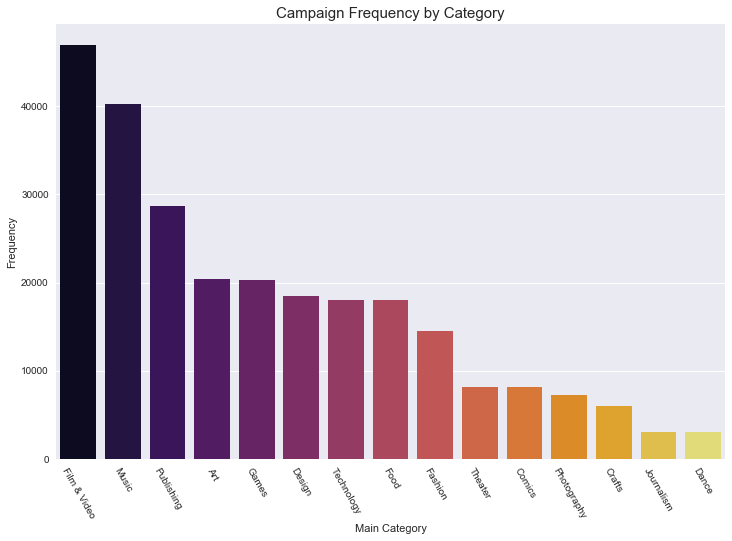

In [48]:
data1 = data.groupby(['Main_Category'],as_index=False).size()
data1 = data1.to_frame(name = 'Count').reset_index()
data1 = data1 [['Main_Category','Count']]
data1 = data1.sort_values(['Count'],ascending=False).reset_index(drop = True)

#display in tabular format
print ("Campaign Frequency by Main Category:")
display(data1)

#display chart
plt.figure(figsize=(12,8))
sns.set(style="darkgrid")
ax = sns.barplot(data1.index, data1.Count, palette="inferno")
ax.set_xticklabels(data1.Main_Category)
ax.set(xlabel='Main Category', ylabel='Frequency')
plt.title("Campaign Frequency by Category",fontsize = 15)
plt.xticks(rotation=-60)


## Campaign Frequency by SubCategory

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

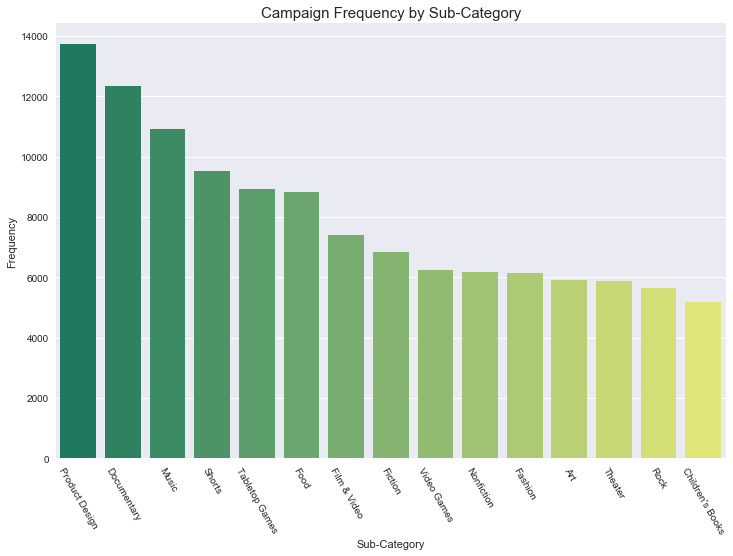

In [49]:
data2 = data.groupby(['Sub_Category']).count().reset_index()
data2 = data2.sort_values('days',ascending=False).reset_index(drop = True)
data2 = data2[['Sub_Category','days']]
data3 = data2[0:15]
data3['Sub_Category'] = data3['Sub_Category'].cat.remove_unused_categories()
data3 = data3.sort_values(['days'],ascending=False).reset_index(drop = True)


plt.figure(figsize=(12,8))
sns.set(style="darkgrid")
ax1 = sns.barplot(data3.index, data3.days, palette="summer")
ax1.set_xticklabels(data3.Sub_Category)
ax1.set(xlabel='Sub-Category', ylabel='Frequency')
plt.title("Campaign Frequency by Sub-Category",fontsize = 15)
plt.xticks(rotation=-60)


## Success and Failure rate of Categories

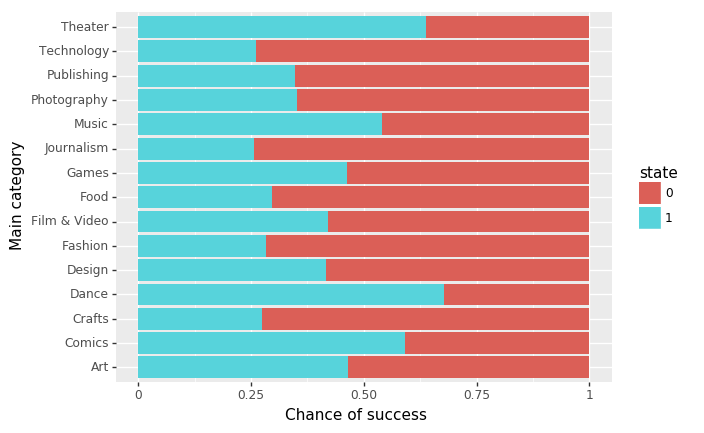

<ggplot: (170859193306)>

In [50]:
top15Cat = data.Main_Category.value_counts().head(25)
top15Overall = data[data.Main_Category.isin(top15Cat.index)]
top15Overall.Main_Category = top15Overall.Main_Category.cat.remove_unused_categories()
(
ggplot(top15Overall, aes('Main_Category', fill = 'state')) +
    geom_bar(position = 'fill') +
    labs(x = 'Main category', y = 'Chance of success') +
    coord_flip()
)

## Projects launched cross the years

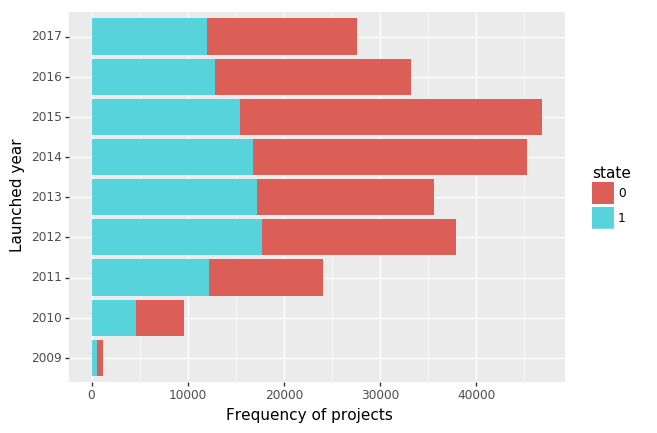

<ggplot: (170859276450)>

In [51]:
(
ggplot(data, aes('launched_year', fill = 'state')) +
    geom_bar() +
    labs(x = 'Launched year', y = 'Frequency of projects') +
    coord_flip()
)

## Project Distribution by Month

Text(0.5,1,'Project Distribution by month')

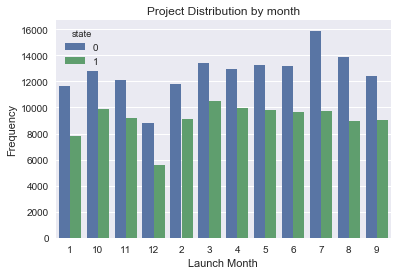

In [52]:
plot = sns.countplot(x = 'launched_month', data = data, hue = 'state')
plot.set(xlabel='Launch Month', ylabel='Frequency')
plt.title("Project Distribution by month",fontsize = 12)


## Project Distribution by Days

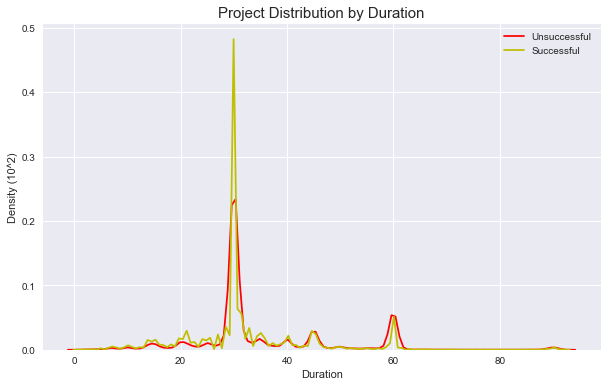

In [56]:
target_0 = data[data['state'] == '0'] 
target0_days = target_0.loc[:, ['days']]

target_1 = data[data['state'] == '1'] 
target1_days = target_1.loc[:, ['days']]

plt.figure(figsize=(10,6))
sns.set(style="darkgrid")
ax2 = sns.distplot(target0_days['days'],color = 'r',hist = False,label = 'Unsuccessful')
ax2 = sns.distplot(target1_days['days'],color = 'y',hist = False,label = 'Successful')
ax2.set(xlabel='Duration', ylabel='Density (10^2)')
plt.title("Project Distribution by Duration",fontsize = 15)
plt.show()


## Avg Days vs Avg Backers

<Figure size 864x864 with 0 Axes>

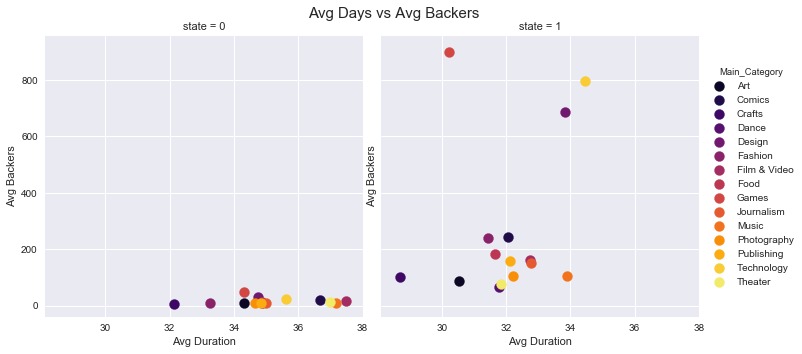

In [57]:
day_backer = data.groupby(['Main_Category','state'],as_index=False).mean()
day_backer = day_backer[['Main_Category','state','backers','days']]

plt.figure(figsize=(12,12))
sns.set(style="darkgrid")
ax3 = sns.FacetGrid(day_backer, col="state",hue = 'Main_Category',size=5,sharex=True, sharey=True,palette = 'inferno') 
ax3.map(plt.scatter, "days", "backers",s = 100)
ax3.add_legend() 
ax3.set(xlabel='Avg Duration', ylabel='Avg Backers')
ax3.fig.suptitle('Avg Days vs Avg Backers',fontsize = 15)
ax3.fig.subplots_adjust(top=0.9)
plt.show()


## Avg Goal across Categories

Avg Goal across Categories:


,Main_Category,goal
0,Technology,98820.16
1,Journalism,80283.47
2,Film & Video,72271.05
3,Games,43053.65
4,Design,39184.82
5,Food,34349.93
6,Art,32272.32
7,Theater,23231.68
8,Comics,23004.94
9,Fashion,22597.24


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

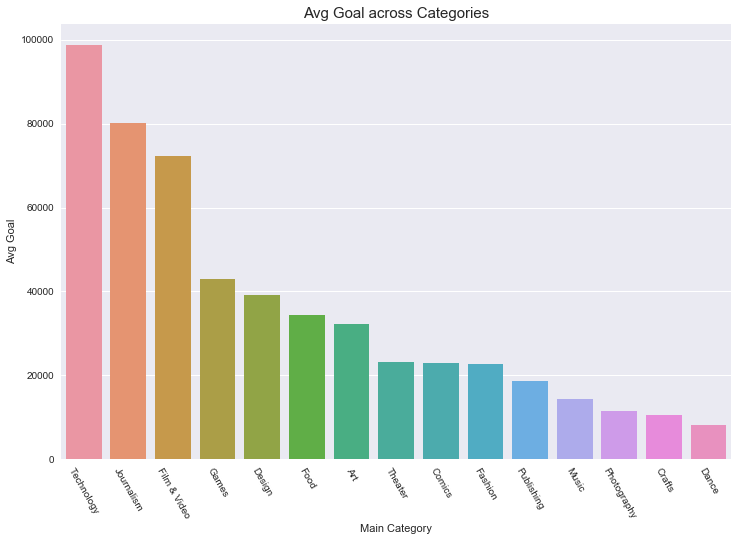

In [58]:
avggoal = data.groupby(['Main_Category'],as_index=False).mean().reset_index(drop= True)
avggoal = avggoal[["Main_Category","goal"]]
avggoal = avggoal.sort_values(["goal"],ascending=False).reset_index(drop = True)
print ("Avg Goal across Categories:")
display(avggoal)

plt.figure(figsize=(12,8))
sns.set(style="darkgrid")
ax5 = sns.barplot(avggoal.index, avggoal.goal)
ax5.set_xticklabels(avggoal.Main_Category)
ax5.set(xlabel='Main Category', ylabel='Avg Goal')
plt.title("Avg Goal across Categories",fontsize = 15)
plt.xticks(rotation=-60)

## Avg Backers per Category

Avg Backers per Category:


,Main_Category,backers
0,Games,442.24
1,Design,304.45
2,Technology,224.75
3,Comics,152.29
4,Film & Video,76.66
5,Fashion,75.10
6,Food,64.25
7,Publishing,61.21
8,Music,60.51
9,Theater,52.58


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

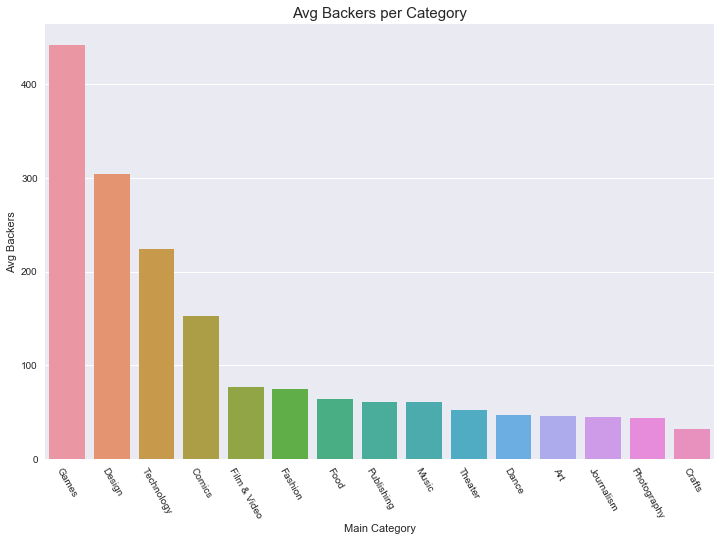

In [59]:
avgbacker = data.groupby(['Main_Category'],as_index=False).mean().reset_index(drop= True)
avgbacker = avgbacker[["Main_Category","backers"]]
avgbacker = avgbacker.sort_values(["backers"],ascending=False).reset_index(drop = True)
print ("Avg Backers per Category:")
display(avgbacker)

plt.figure(figsize=(12,8))
sns.set(style="darkgrid")
ax6 = sns.barplot(avgbacker.index, avgbacker.backers)
ax6.set_xticklabels(avgbacker.Main_Category)
ax6.set(xlabel='Main Category', ylabel='Avg Backers')
plt.title("Avg Backers per Category",fontsize = 15)
plt.xticks(rotation=-60)

## Average Pledge by an individual per Category

Avg Pledge per Individual across categories:


,Main_Category,aip
0,Technology,129.78
1,Design,99.43
2,Food,95.32
3,Film & Video,93.69
4,Photography,91.22
5,Fashion,89.42
6,Theater,84.97
7,Dance,80.88
8,Art,77.07
9,Music,71.73


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

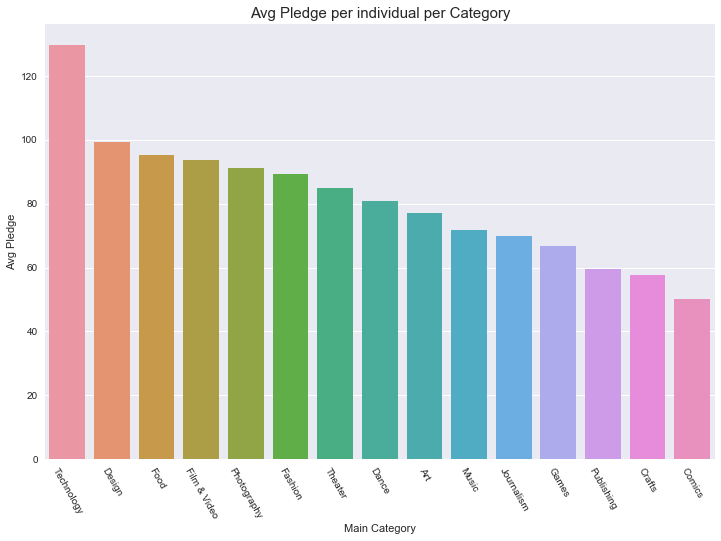

In [60]:
avgpledge = data.groupby(['Main_Category'],as_index=False).mean().reset_index(drop= True)
avgpledge['aip'] = avgpledge['pledged']/avgpledge['backers']
avgpledge = avgpledge[["Main_Category","aip"]]
avgpledge = avgpledge.sort_values(["aip"],ascending=False).reset_index(drop = True)
print ("Avg Pledge per Individual across categories:")
display(avgpledge)

plt.figure(figsize=(12,8))
sns.set(style="darkgrid")
ax4 = sns.barplot(avgpledge.index, avgpledge.aip)
ax4.set_xticklabels(avgpledge.Main_Category)
ax4.set(xlabel='Main Category', ylabel='Avg Pledge')
plt.title("Avg Pledge per individual per Category",fontsize = 15)
plt.xticks(rotation=-60)

## Funding vs Goal

<Figure size 864x576 with 0 Axes>

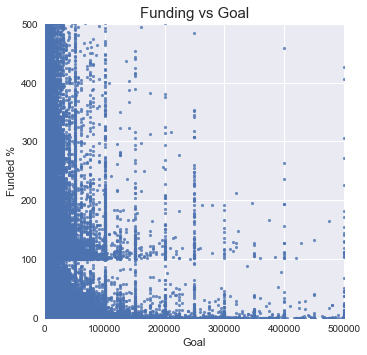

In [61]:
plt.figure(figsize=(12,8))
ax7=sns.lmplot('goal','ratio',data,fit_reg=False,size=5,scatter_kws={"s": 10})
ax7.set(xlabel='Goal', ylabel='Funded %')
plt.title("Funding vs Goal",fontsize = 15)
plt.xlim(0, 500000)
plt.ylim(0, 500)
plt.show()

#this chart shows that if you put up a goal of more than 100k, the chances of you getting funding reduce furter and further.
#below 100k also points to ovefunding
#highest percentage of funding is at goals < 50k

# Classification Modelling

In [62]:
# exclude unwanted columns for prediction
data_model = data.drop(columns=['deadline','launched','pledged','backers','ratio','launched_year','deadline_year'])

In [63]:
#split dataset into training and testing subsets
train, test = train_test_split(data_model, test_size = 0.33)

In [64]:
# One Hot Encoding for categorical variables in both training and test dataset
train = train.select_dtypes(exclude = ['number']).apply(LabelEncoder().fit_transform).join(train.select_dtypes(include = ['number']))
test = test.select_dtypes(exclude = ['number']).apply(LabelEncoder().fit_transform).join(test.select_dtypes(include = ['number']))

In [65]:
# split train and test into predictors and output variables
train_X = train.loc[:, train.columns != 'state']
train_Y = train.loc[:, 'state']
test_X = test.loc[:, train.columns != 'state']
test_Y = test.loc[:, 'state']

### Random Forest Classifier

In [66]:
#Model Fitting and Predictions
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(train_X, train_Y)
predictions = rf.predict(test_X)
#acc = roc_auc_score(test_Y, predictions)

In [67]:
#Accuracy
test_a  = accuracy_score(test_Y, predictions)
print ("Test Accuracy  :: " + "{:.2%}".format(test_a))

Test Accuracy  :: 63.47%


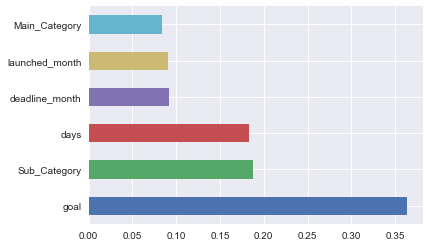

In [68]:
#Feature importance
list(zip(train_X.columns,rf.feature_importances_))
feat_importances = pd.Series(rf.feature_importances_, index=train_X.columns)
feat_importances.nlargest(6).plot(kind='barh')

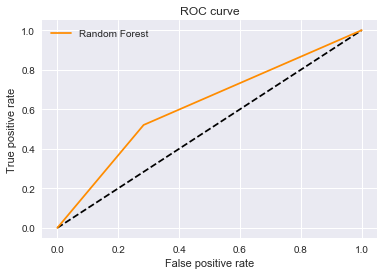

ROC AUC Score is::0.6185676028550676


In [69]:
#ROC CURVE
from sklearn.metrics import roc_curve, roc_auc_score
false_positive, true_positive, _ = roc_curve(test_Y, predictions)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve' )
plt.legend(loc='best')
plt.show()
#print(auc(false_positive,true_positive))
print("ROC AUC Score is::" + str(roc_auc_score(test_Y, predictions)))


In [70]:
#Classification Report
cr_rf = classification_report(test_Y, predictions)
print(cr_rf)

             precision    recall  f1-score   support

          0       0.68      0.72      0.70     50234
          1       0.57      0.52      0.54     36015

avg / total       0.63      0.63      0.63     86249



## Logistic Regression

In [71]:
lr = LogisticRegression()
lr.fit(train_X, train_Y)
predictions_l = lr.predict(test_X)

In [72]:
#Accuracy
test_b  = accuracy_score(test_Y, predictions_l)
print ("Test Accuracy  :: " + "{:.2%}".format(test_b))

Test Accuracy  :: 60.04%


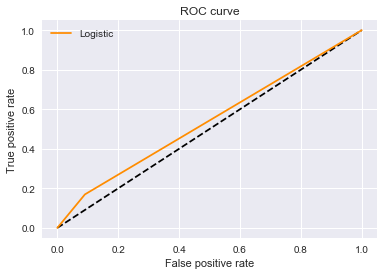

0.5393611644553331


In [73]:
#ROC CURVE
false_positive, true_positive, _ = roc_curve(test_Y, predictions_l)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive, true_positive, color='darkorange', label='Logistic')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve' )
plt.legend(loc='best')
plt.show()

#print(auc(false_positive,true_positive))
print(roc_auc_score(test_Y, predictions_l))


In [74]:
cr_log = classification_report(test_Y, predictions_l)
print(cr_log)

             precision    recall  f1-score   support

          0       0.60      0.91      0.73     50234
          1       0.57      0.17      0.26     36015

avg / total       0.59      0.60      0.53     86249



## kNN

In [75]:
classifier = KNeighborsClassifier(n_neighbors=9)  
classifier.fit(train_X, train_Y) 
predictions_k = classifier.predict(test_X)

In [76]:
#Accuracy
test_c  = accuracy_score(test_Y, predictions_k)
print ("Test Accuracy  :: " + "{:.2%}".format(test_b))

Test Accuracy  :: 60.04%


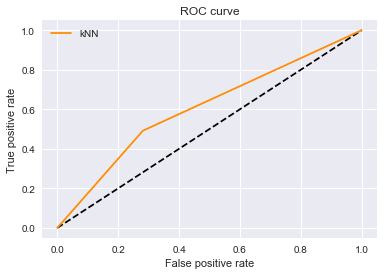

0.6052264028530844


In [77]:
#ROC CURVE
false_positive, true_positive, _ = roc_curve(test_Y, predictions_k)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive, true_positive, color='darkorange', label='kNN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve' )
plt.legend(loc='best')
plt.show()

#print(auc(false_positive,true_positive))
print(roc_auc_score(test_Y, predictions_k))


In [78]:
cr_k = classification_report(test_Y, predictions_k)
print(cr_k)

             precision    recall  f1-score   support

          0       0.66      0.72      0.69     50234
          1       0.56      0.49      0.52     36015

avg / total       0.62      0.62      0.62     86249

